In [2]:
import numpy as np
import qutip as qutip

from matplotlib import pyplot as plt

import time as time

import sys
import os
sys.path.append('../../../utils')

from tomography import coherent_state_tomography_copy as cst2
from quantum_utils import quantum_optics_utils as qou

In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Noise tomography

In [4]:
noise_dim = 25
max_x = 5
mesh_size = 0.25

povm, alphas, xs, ps = cst2.generate_coherent_state_POVM(max_x,
                                                         mesh_size,
                                                         noise_dim,
                                                         cutoff=0)

Generating coherent state mesh took 7.661741256713867 s.


In [5]:
avg_number_of_noise_photons = 1
rho_noise = qutip.thermal_dm(noise_dim, avg_number_of_noise_photons)
noise_q_func = qutip.qfunc(rho_noise, xs, ps, g=2)

In [6]:
number_of_mle_iterations = 1000
old_reconstructed_noise_state, _ = \
    cst2.perform_coherent_state_MLE(
        povm,
        noise_q_func,
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        identity_mixin=0,
        number_of_photons=1)

Non-inlined, unflattened, untruncated coherent state MLE of 1 photon mode(s) and a Fock space  dimension of 25 took 472.3741157054901 seconds  for 1000.


In [7]:
print(qutip.fidelity(old_reconstructed_noise_state, rho_noise))

0.9966846079097754


<IPython.core.display.Javascript object>


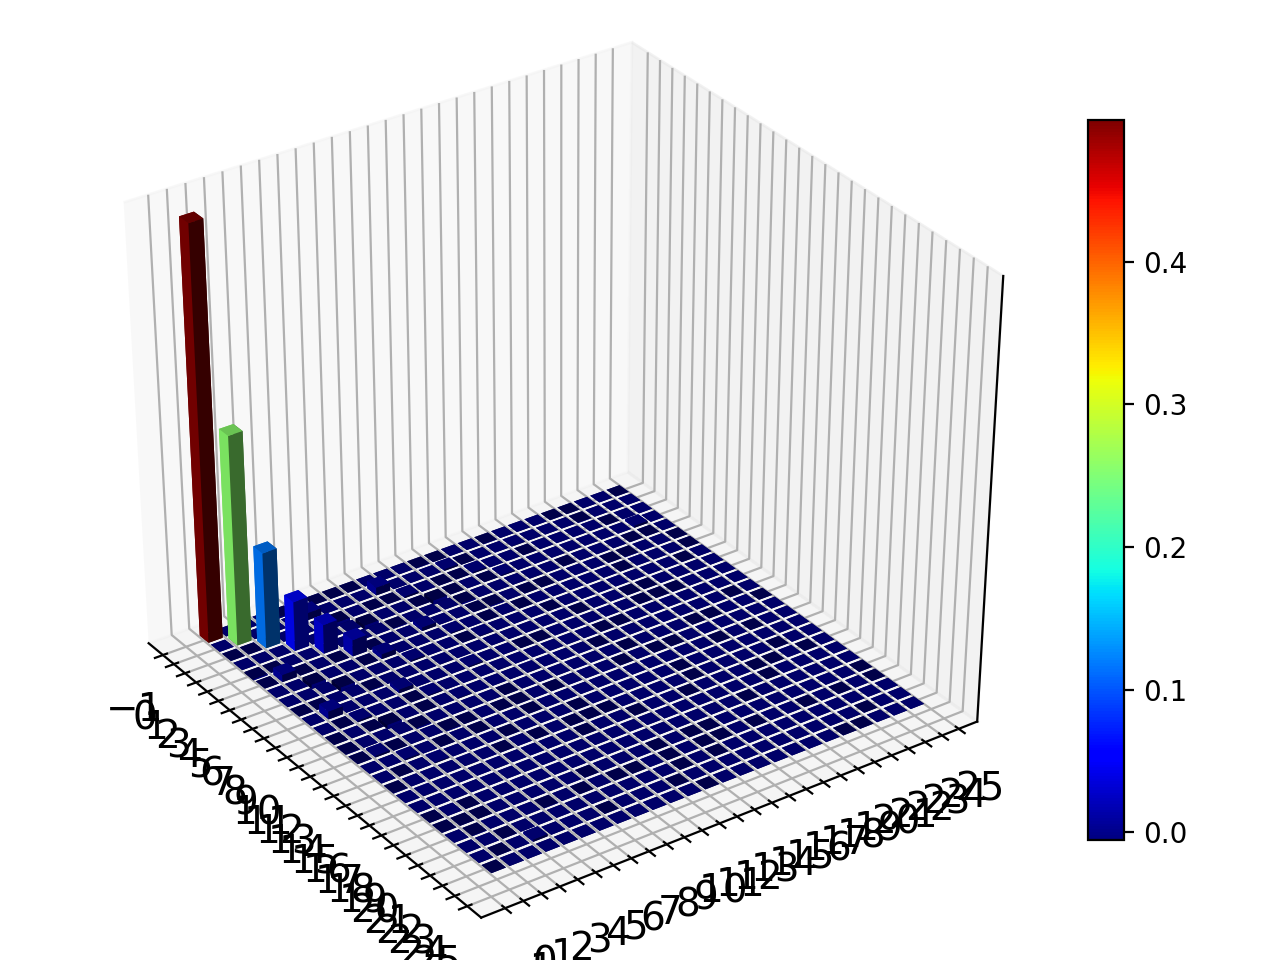

/usr/local/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1773: RuntimeWarning: divide by zero encountered in true_divide
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))


<IPython.core.display.Javascript object>


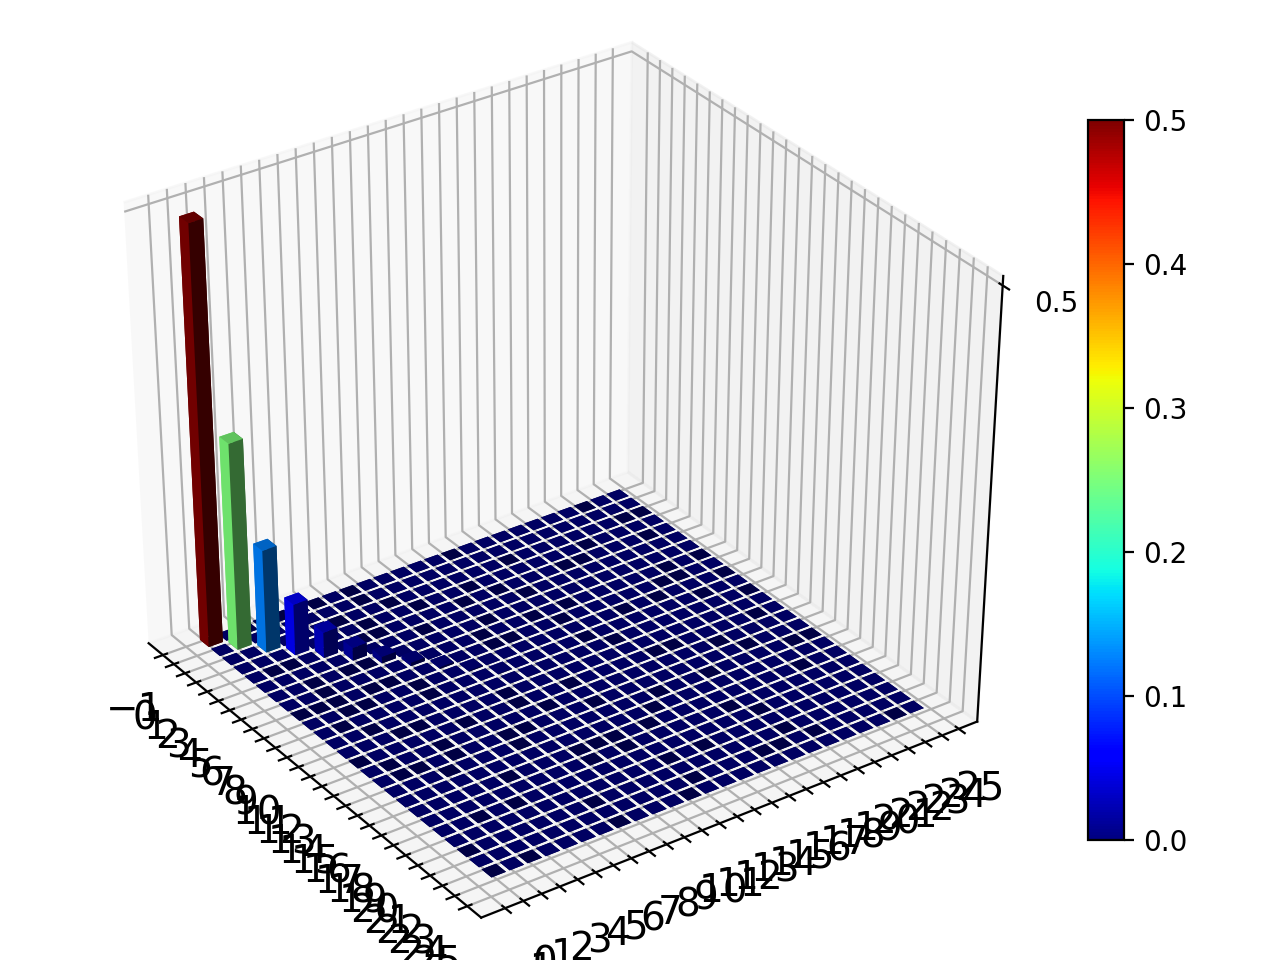

(<Figure size 640x480 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x130118990>)

In [8]:
qutip.visualization.matrix_histogram(old_reconstructed_noise_state)
qutip.visualization.matrix_histogram(rho_noise)

# Visualize the data
This step is important for setting mesh parameters to ensure you are using a large enough mesh

In [9]:
# Generate the POVM
max_x = 4 # We're going to be truncating anyways, so we can cut this max x down in size prematurely
mesh_size = 1
noisy_povm, alphas, xs, ps = cst2.generate_coherent_state_POVM(max_x,
                                                         mesh_size,
                                                         noise_dim,
                                                         cutoff=0,
                                                         noise_base=rho_noise)

Generating coherent state mesh took 0.37659502029418945 s.


In [10]:
# Generate the noisy signal data
signal_state = (qutip.basis(noise_dim, 0) + qutip.basis(noise_dim, 1)).unit()
noisy_signal_data = cst2.evaluate_thermally_noisy_Q_function(signal_state, avg_number_of_noise_photons, xs, ps)
clean_signal_data = cst2.evaluate_thermally_noisy_Q_function(signal_state, 0, xs, ps)

<IPython.core.display.Javascript object>


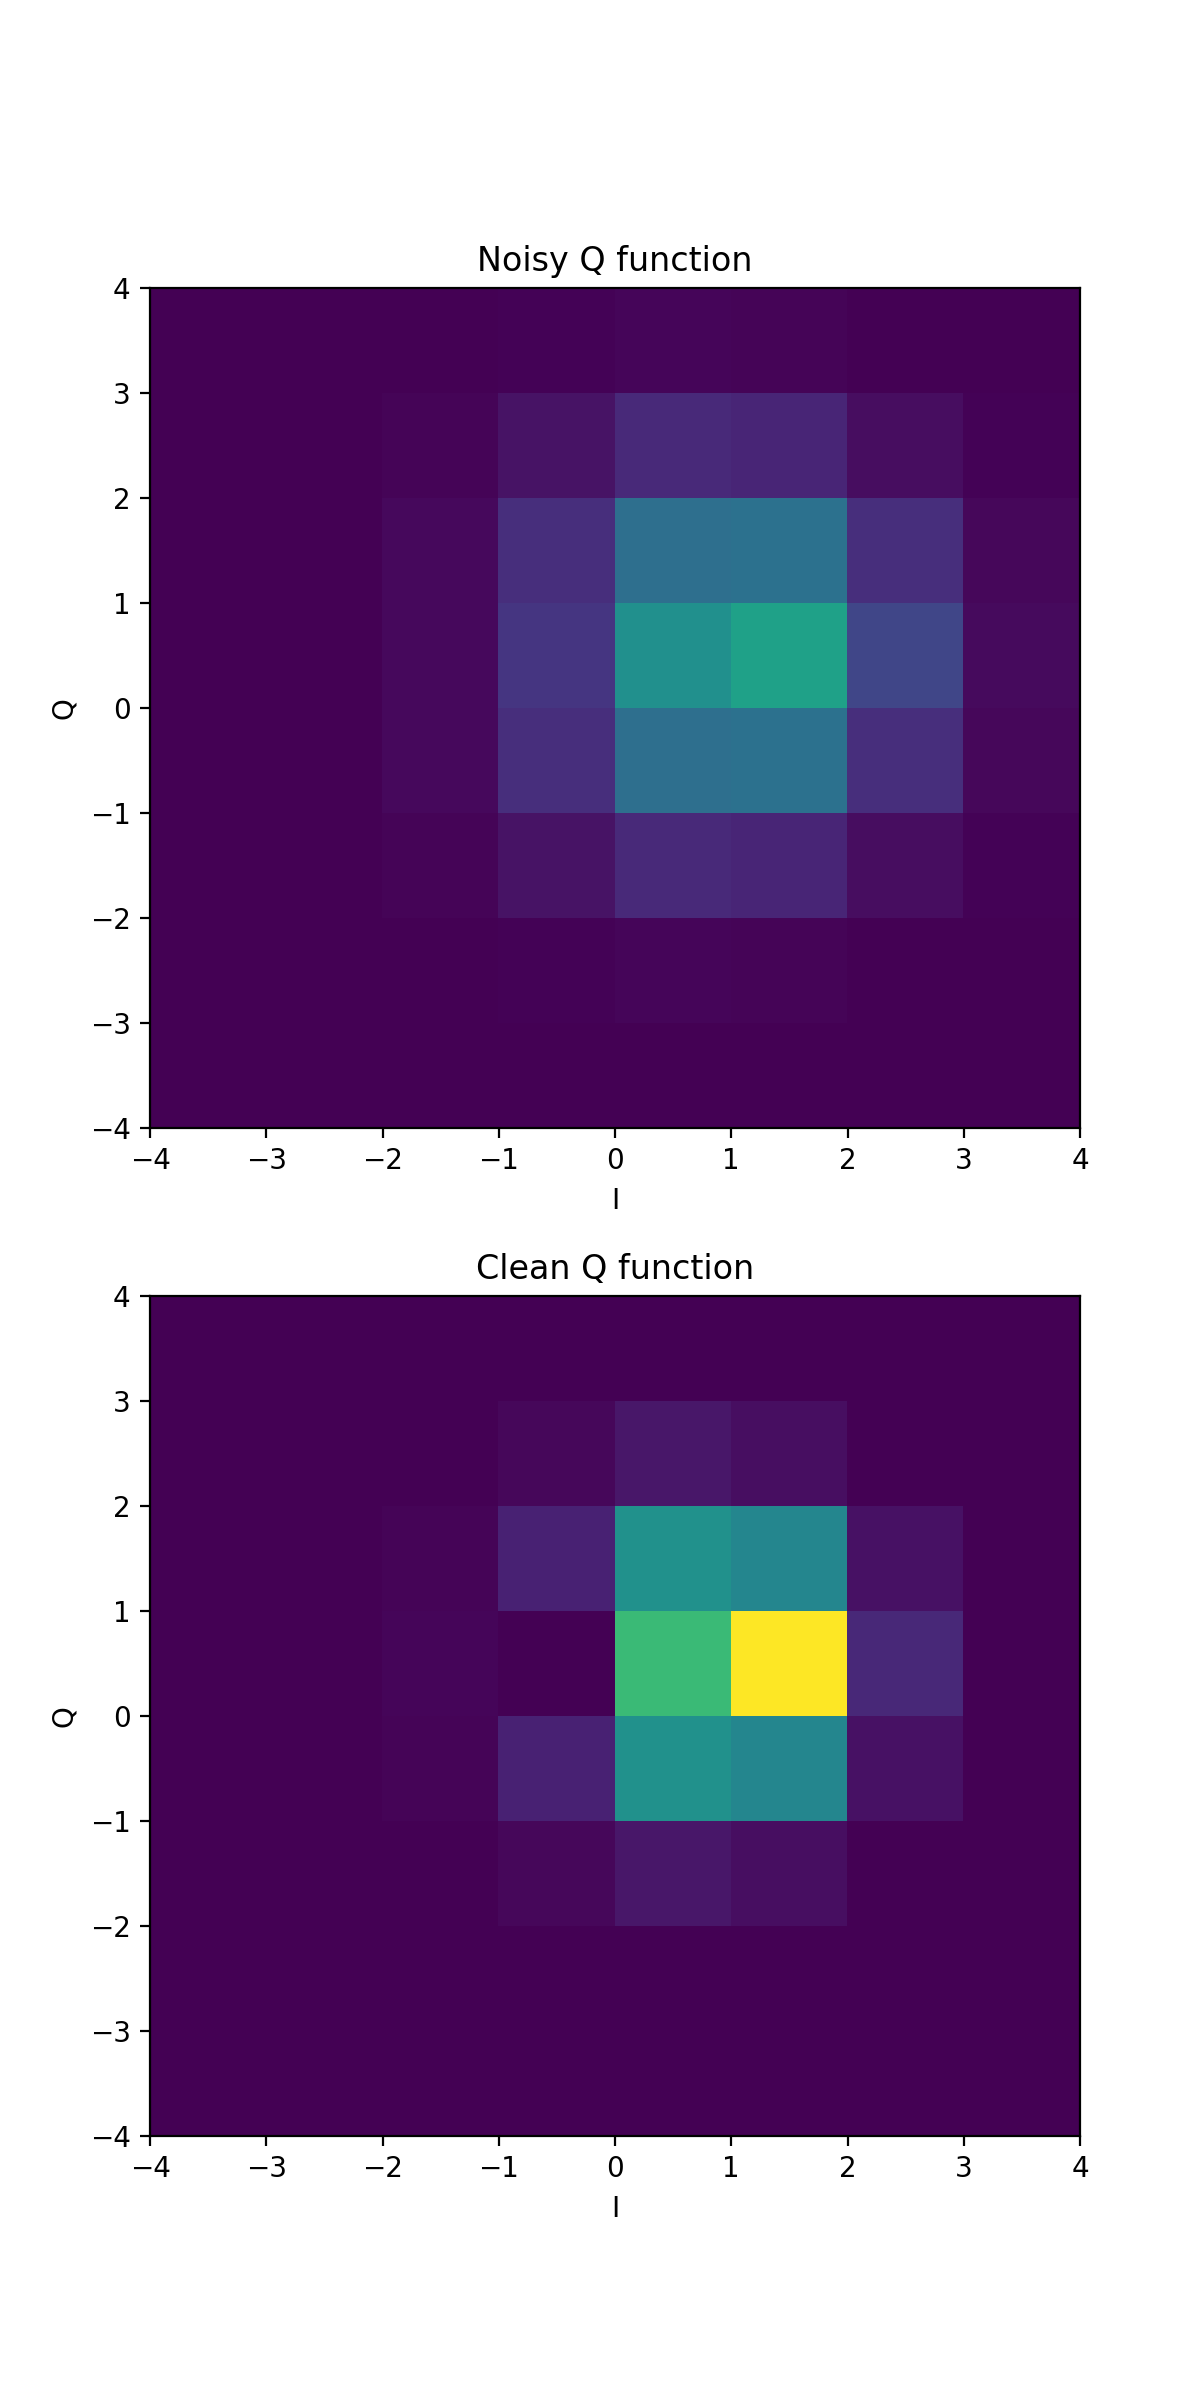

In [11]:
# Visualize the clean and noisy Q functions
fig, ax = plt.subplots(2, 1, figsize=(6, 12))
data_sets = [noisy_signal_data, clean_signal_data]
cst2.plot_images(data_sets, xs, ps, ax, ['I', 'I'], ['Q', 'Q'], ['Noisy Q function', 'Clean Q function'])

# Truncated dimension = 2

In [12]:
# Generate a reduced noisy POVM and the noisy Q function to the smaller Fock space dimension
truncated_dim = 2
truncated_noisy_povm = cst2.truncate_povm(noisy_povm, truncated_dim)
noisy_signal_data = cst2.evaluate_thermally_noisy_Q_function(signal_state, avg_number_of_noise_photons, xs, ps)
s0 = (qutip.basis(truncated_dim, 0) + qutip.basis(truncated_dim, 1)).unit()
rho_ideal = s0*s0.dag()

In [13]:
number_of_mle_iterations = 1000
reconstructed_signal_state_dim2_small_mesh, intermediate_fidelities, lls = \
    cst2.perform_coherent_state_MLE(
        truncated_noisy_povm,
        noisy_signal_data,
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        identity_mixin=0,
        number_of_photons=1,
        rho_ideal=rho_ideal)

Non-inlined, unflattened, untruncated coherent state MLE of 1 photon mode(s) and a Fock space  dimension of 2 took 22.906793117523193 seconds  for 1000.


<IPython.core.display.Javascript object>


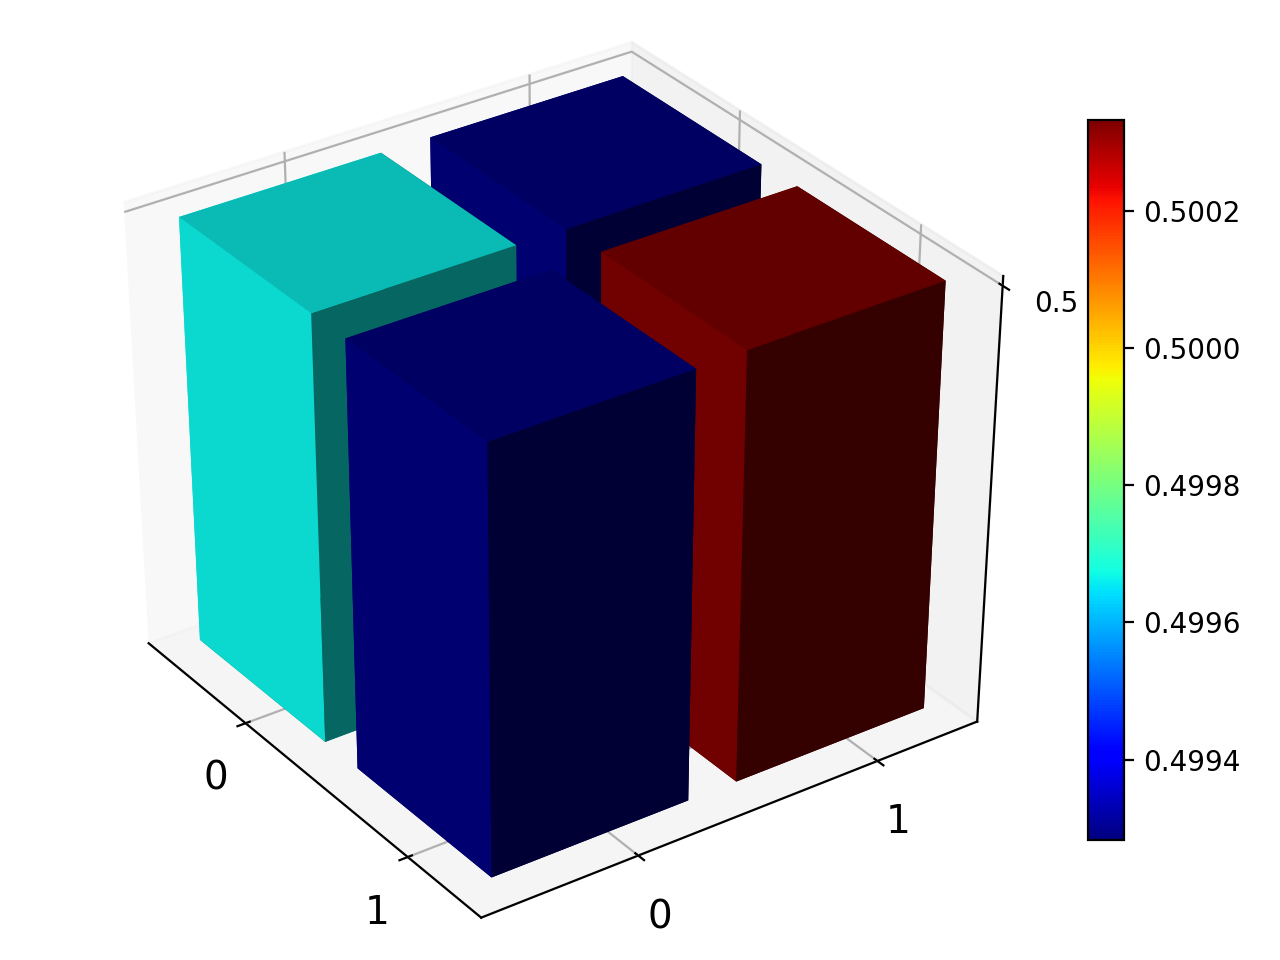

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.4996676 0.4992828]
 [0.4992828 0.5003324]]
0.9996413354205649


In [14]:
qutip.visualization.matrix_histogram(reconstructed_signal_state_dim2_small_mesh)
print(reconstructed_signal_state_dim2_small_mesh)
print(qutip.fidelity(reconstructed_signal_state_dim2_small_mesh, rho_ideal))

<IPython.core.display.Javascript object>


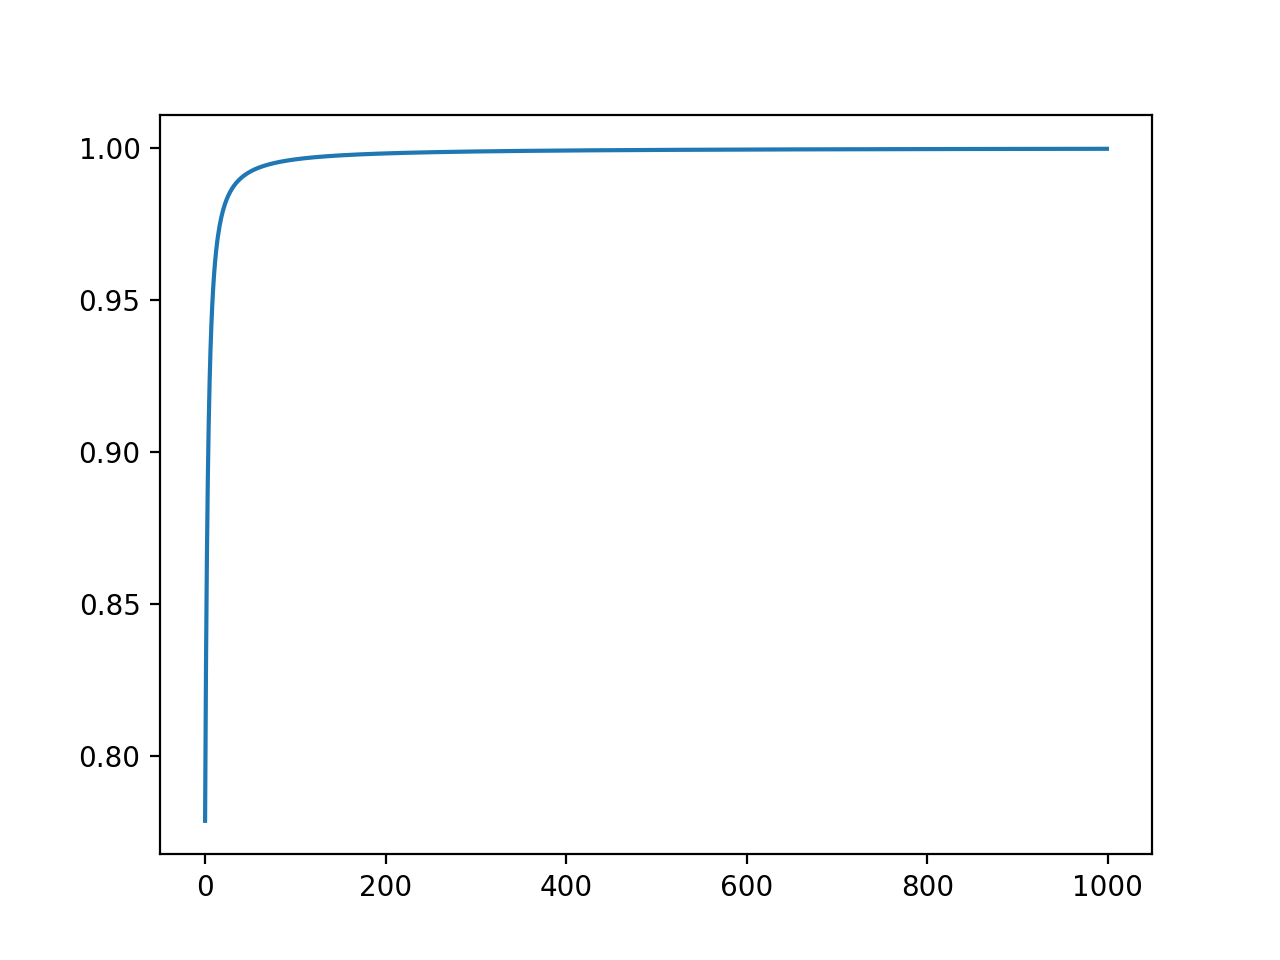

In [15]:
fig, ax = plt.subplots()
ax.plot(intermediate_fidelities)

# Truncated dimension = 3, larger mesh
To make sure the truncated reconstruction isn't suspect, we also perform reconstruction with a higher truncation dimension and make sure that the density matrix elements involving n > 1 are 0

In [16]:
# Generate a reduced noisy POVM and the noisy Q function to the smaller Fock space dimension
truncated_dim = 3
truncated_noisy_povm_dim3 = cst2.truncate_povm(noisy_povm, truncated_dim)
noisy_signal_data_dim3 = cst2.evaluate_thermally_noisy_Q_function(signal_state, avg_number_of_noise_photons, xs, ps)
s0 = (qutip.basis(truncated_dim, 0) + qutip.basis(truncated_dim, 1)).unit()
rho_ideal = s0*s0.dag()

In [19]:
number_of_mle_iterations = 5000
reconstructed_signal_state_dim3_small_mesh, intermediate_fidelities_dim3_small_mesh, lls_dim3_small_mesh = \
    cst2.perform_coherent_state_MLE(
        truncated_noisy_povm_dim3,
        noisy_signal_data,
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        identity_mixin=0,
        number_of_photons=1,
        rho_ideal=rho_ideal)

Non-inlined, unflattened, untruncated coherent state MLE of 1 photon mode(s) and a Fock space  dimension of 3 took 113.9267680644989 seconds  for 5000.


<IPython.core.display.Javascript object>


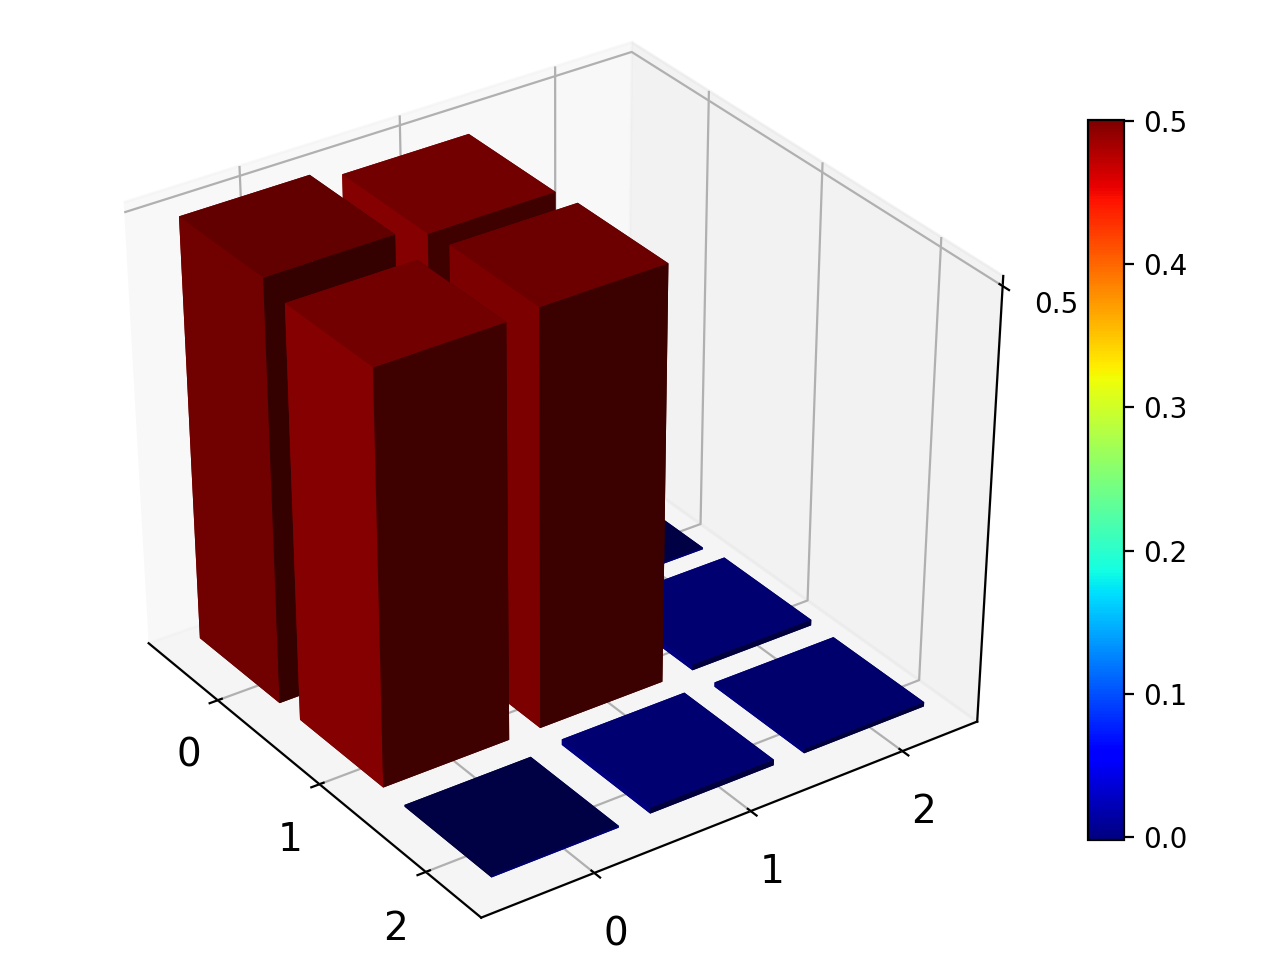

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.5006644   0.48961863 -0.00210421]
 [ 0.48961863  0.49405785  0.00690347]
 [-0.00210421  0.00690347  0.00527776]]
0.9934685472378781


<IPython.core.display.Javascript object>


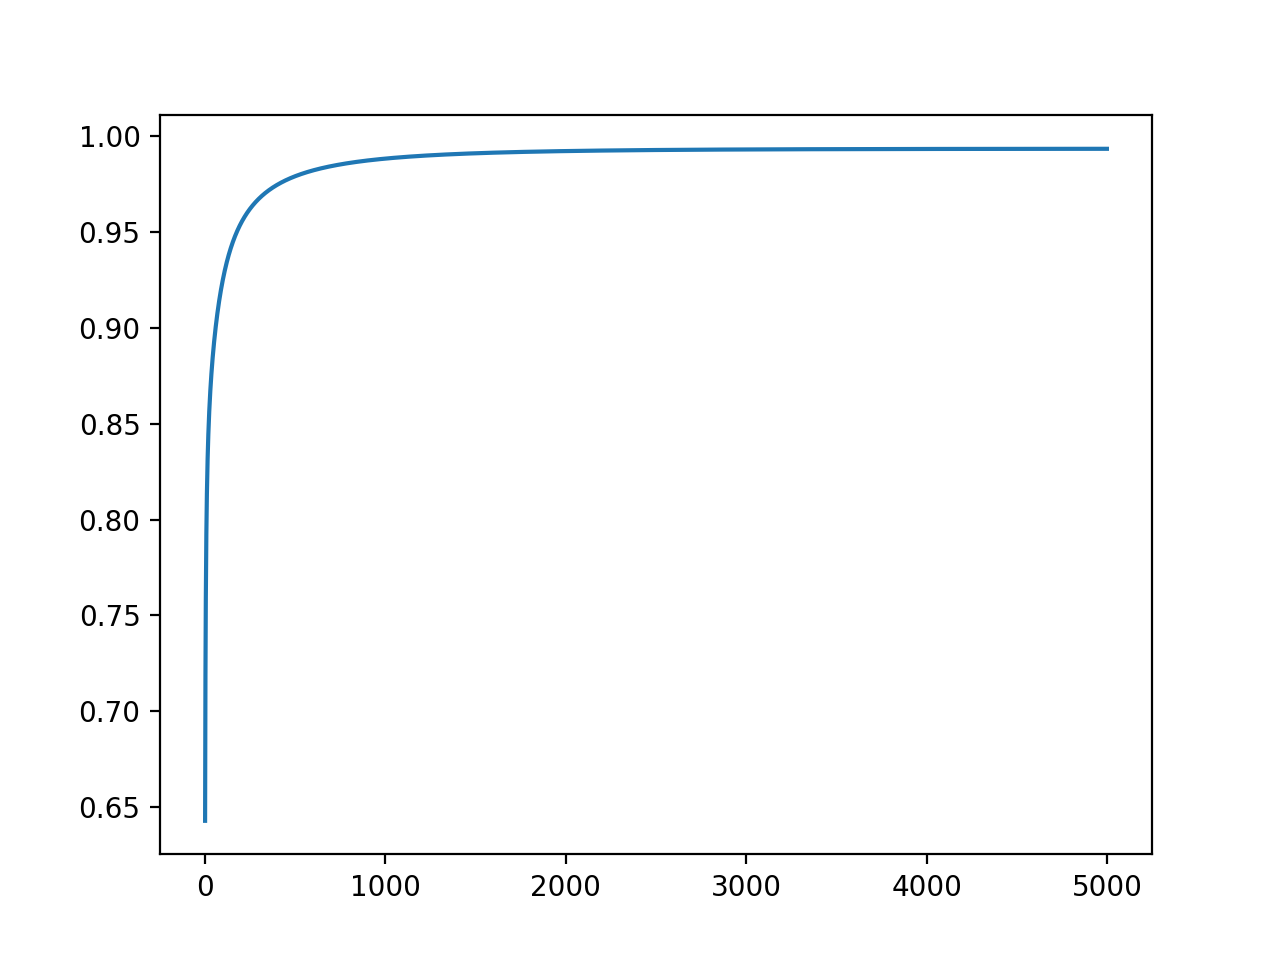

In [20]:
qutip.visualization.matrix_histogram(reconstructed_signal_state_dim3_small_mesh)
print(reconstructed_signal_state_dim3_small_mesh)
print(qutip.fidelity(reconstructed_signal_state_dim3_small_mesh, rho_ideal))
fig, ax = plt.subplots()
ax.plot(intermediate_fidelities_dim3_small_mesh)

# More noise
It's important to see if adding more noise will cause things to fail. We'll assume a fairly bad case of 3 noise photons first and see if we can still recover the target state. We'll begin still using 8 bins along each quadrature.

In [41]:
# Noise tomography
noise_dim = 50
max_x = 5
mesh_size = 0.5

povm, alphas, xs, ps = cst2.generate_coherent_state_POVM(max_x,
                                                         mesh_size,
                                                         noise_dim,
                                                         cutoff=0)

avg_number_of_noise_photons = 4
rho_noise = qutip.thermal_dm(noise_dim, avg_number_of_noise_photons)
noise_q_func = qutip.qfunc(rho_noise, xs, ps, g=2)

number_of_mle_iterations = 100
old_reconstructed_noise_state, _ = \
    cst2.perform_coherent_state_MLE(
        povm,
        noise_q_func,
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        identity_mixin=0,
        number_of_photons=1)

Generating coherent state mesh took 3.9284322261810303 s.
Non-inlined, unflattened, untruncated coherent state MLE of 1 photon mode(s) and a Fock space  dimension of 50 took 16.191369771957397 seconds  for 100.


Generating coherent state mesh took 0.8385367393493652 s.


<IPython.core.display.Javascript object>


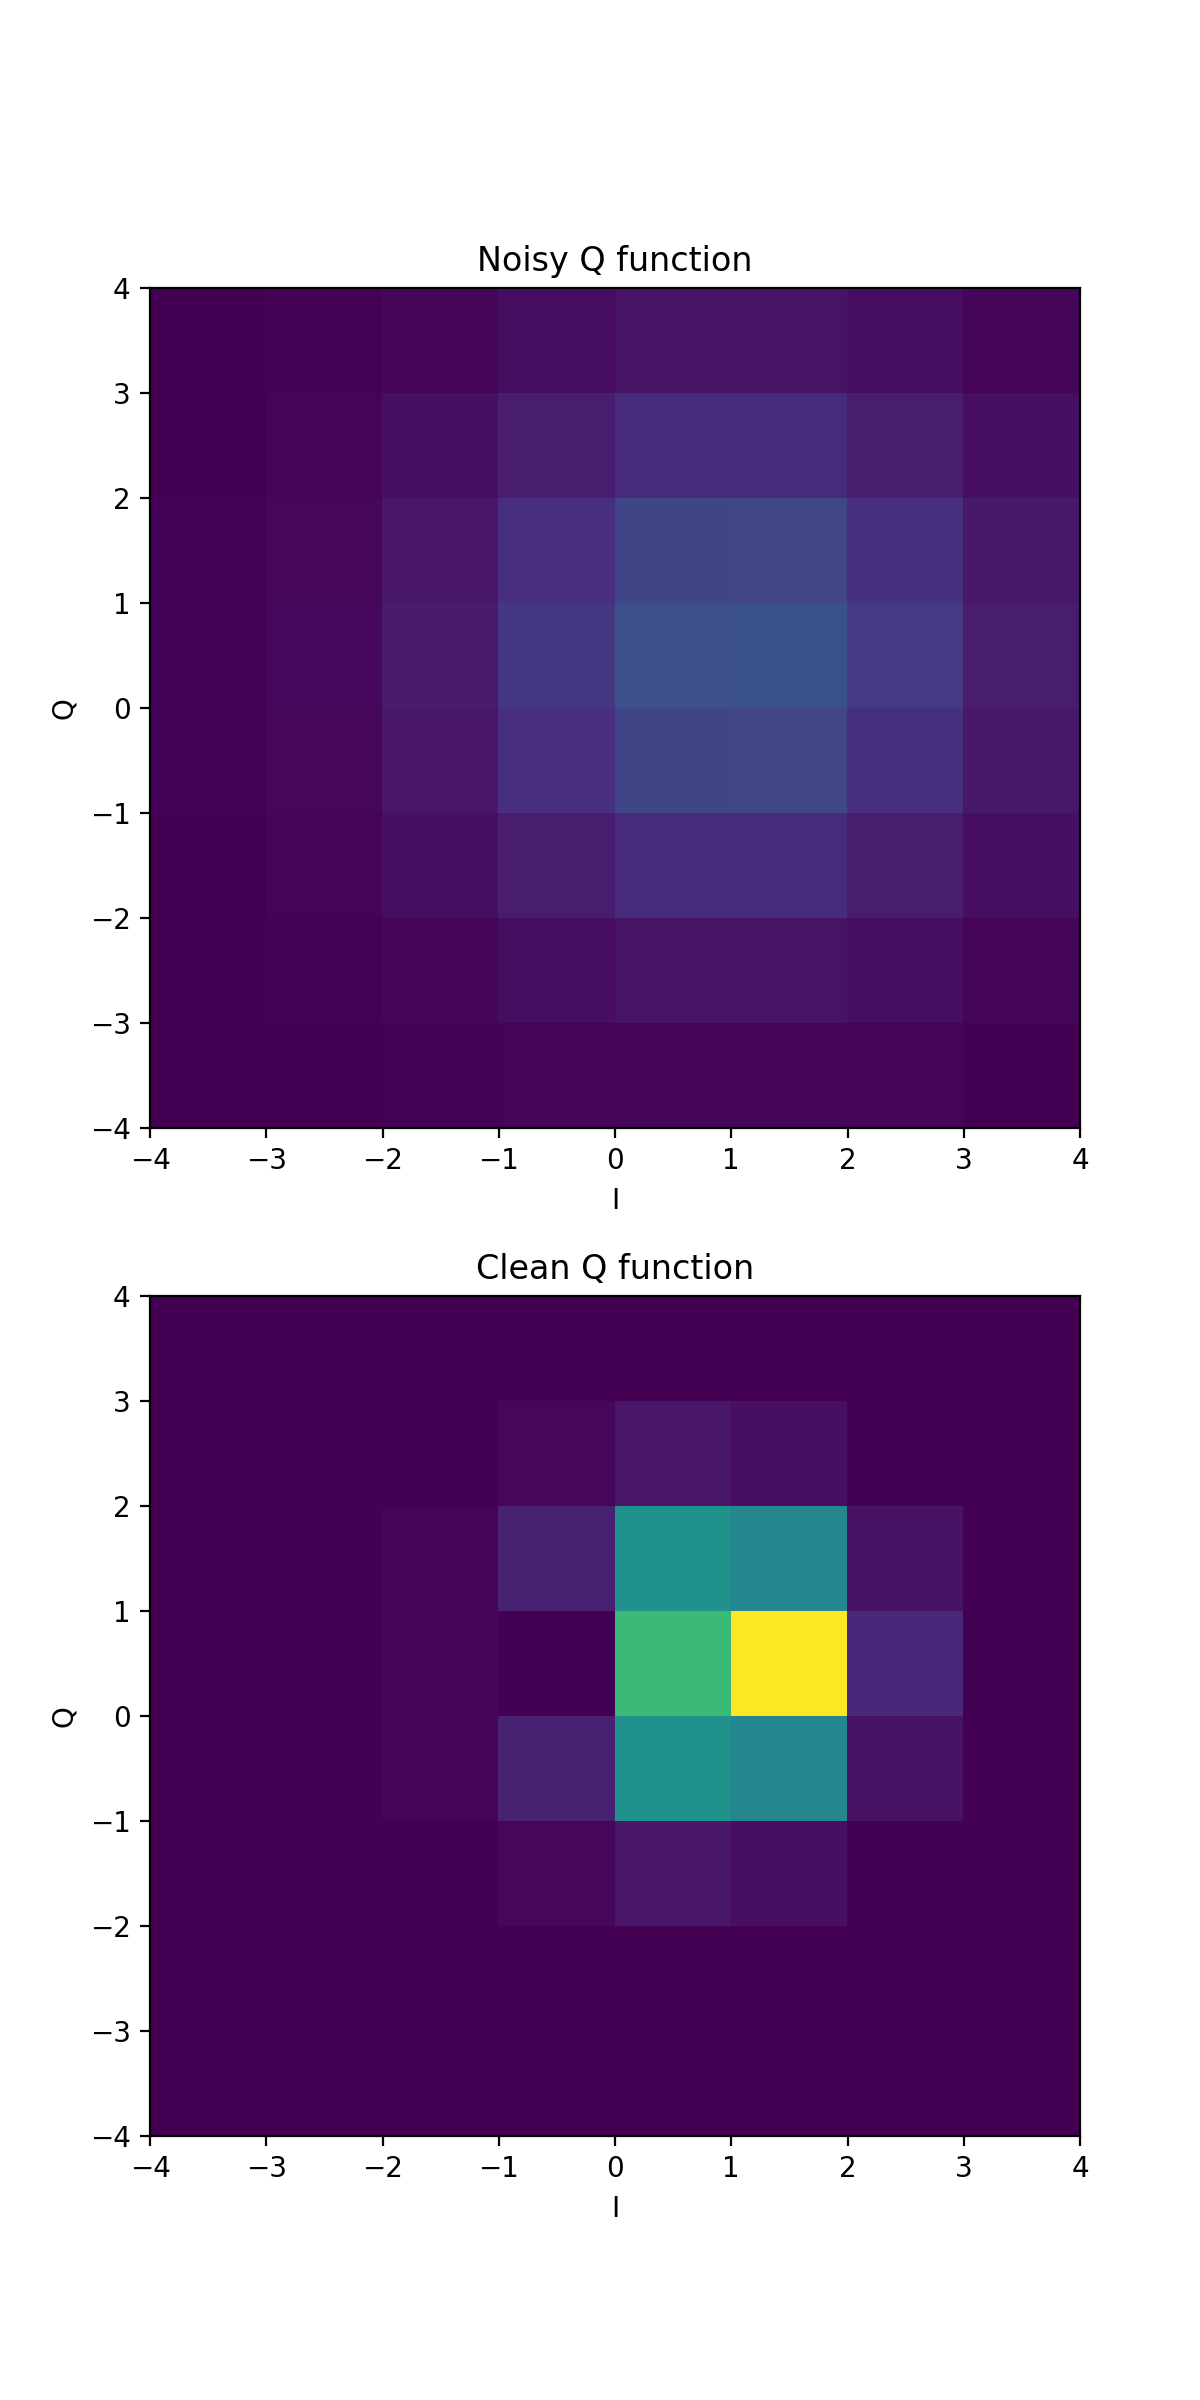

In [42]:
# Generate and visualize signal data
max_x = 4 # We're going to be truncating anyways, so we can cut this max x down in size prematurely
mesh_size = 1
noisy_povm, alphas, xs, ps = cst2.generate_coherent_state_POVM(max_x,
                                                         mesh_size,
                                                         noise_dim,
                                                         cutoff=0,
                                                         noise_base=rho_noise)

# Generate the noisy signal data
signal_state = (qutip.basis(noise_dim, 0) + qutip.basis(noise_dim, 1)).unit()
noisy_signal_data = cst2.evaluate_thermally_noisy_Q_function(signal_state, avg_number_of_noise_photons, xs, ps)
clean_signal_data = cst2.evaluate_thermally_noisy_Q_function(signal_state, 0, xs, ps)

# Visualize the clean and noisy Q functions
fig, ax = plt.subplots(2, 1, figsize=(6, 12))
data_sets = [noisy_signal_data, clean_signal_data]
cst2.plot_images(data_sets, xs, ps, ax, ['I', 'I'], ['Q', 'Q'], ['Noisy Q function', 'Clean Q function'])

In [43]:
# Do the reconstruction...
# Generate a reduced noisy POVM and the noisy Q function to the smaller Fock space dimension
truncated_dim = 2
truncated_noisy_povm = cst2.truncate_povm(noisy_povm, truncated_dim)
noisy_signal_data = cst2.evaluate_thermally_noisy_Q_function(signal_state, avg_number_of_noise_photons, xs, ps)
s0 = (qutip.basis(truncated_dim, 0) + qutip.basis(truncated_dim, 1)).unit()
rho_ideal = s0*s0.dag()

number_of_mle_iterations = 1000
reconstructed_signal_state_dim2_noise3, intermediate_fidelities_noise3, lls = \
    cst2.perform_coherent_state_MLE(
        truncated_noisy_povm,
        noisy_signal_data,
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        identity_mixin=0,
        number_of_photons=1,
        rho_ideal=rho_ideal)

Non-inlined, unflattened, untruncated coherent state MLE of 1 photon mode(s) and a Fock space  dimension of 2 took 21.855740070343018 seconds  for 1000.


<IPython.core.display.Javascript object>


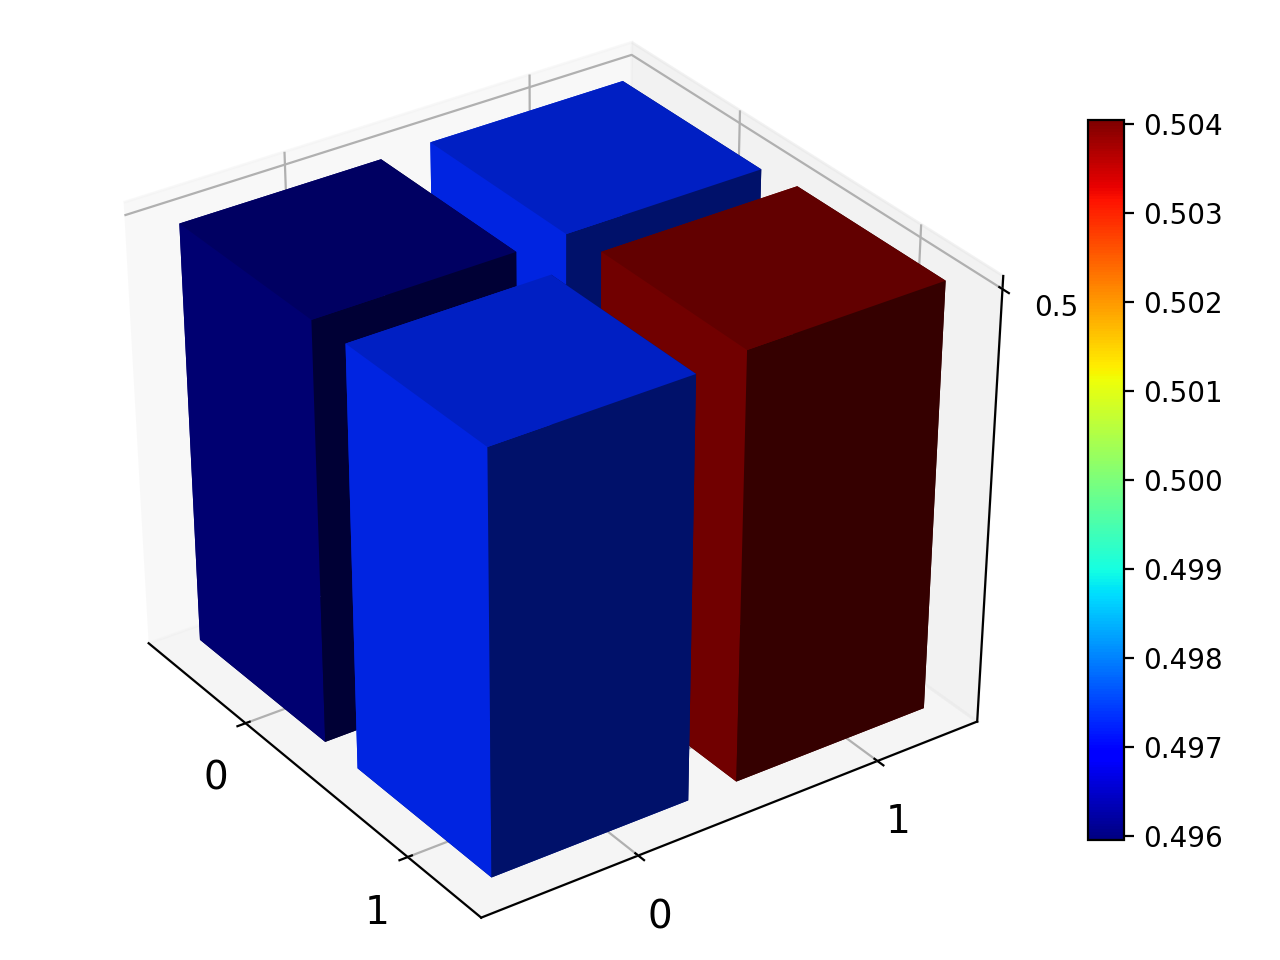

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.4959581  0.49731097]
 [0.49731097 0.5040419 ]]
0.9986545851823371


<IPython.core.display.Javascript object>


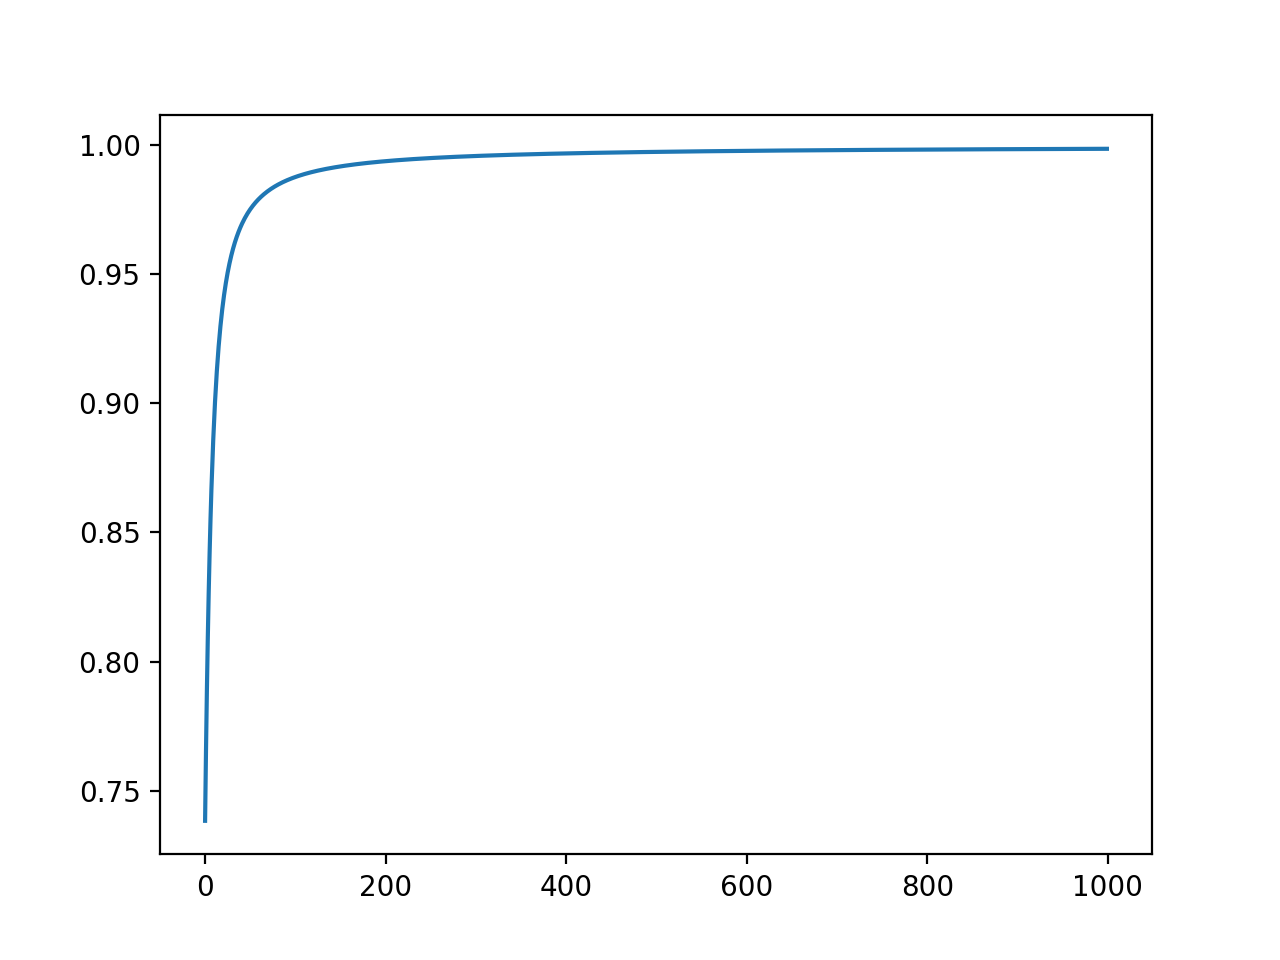

In [44]:
qutip.visualization.matrix_histogram(reconstructed_signal_state_dim2_noise3)
print(reconstructed_signal_state_dim2_noise3)
print(qutip.fidelity(reconstructed_signal_state_dim2_noise3, rho_ideal))
fig, ax = plt.subplots()
ax.plot(intermediate_fidelities_noise3)

# Takeaway
It seems that for 4 photons of noise a mesh halfwidth of 4 still reconstructs things well. This is a little suspicious because the visualized state doesn't look particularly fantastic.

In [ ]:
# The thing to do should be to 